In [42]:
%pip install msgpack-python bson avro msgpack-numpy

  Using cached msgpack-1.0.7-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (530 kB)
You should consider upgrading via the '/home/nano/projects/tree-ensemble-model-management/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import os

import avro.schema
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import msgpack

import xgboost as xgb
from time import time

import tempfile

In [2]:
import math

def mean_and_std(data):
    # Calculate mean
    mean = sum(data) / len(data)

    # Calculate standard deviation
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = math.sqrt(variance)
    
    return mean, std_dev

In [3]:
xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost"

daily_path = xgboost_path + "/daily"
daily_100 = daily_path + "/100trees"
daily_1000 = daily_path + "/1000trees"
daily_10000 = daily_path + "/10000trees"

fivedays_path = xgboost_path + "/5days"
fivedays_100 = fivedays_path + "/100trees"
fivedays_1000 = fivedays_path + "/1000trees"
fivedays_10000 = fivedays_path + "/10000trees"

In [4]:
def load_model_json(model_path):
    booster = xgb.Booster()
    booster.load_model(model_path)
    return booster

def save_model_json(booster, model_path):
    booster.save_model(model_path)

In [5]:
def save_model_avro(booster, model_path_avro, path_avro_schema="xgboost.avsc"):
    # Save the model to a temporary JSON file
    temp_model_path = tempfile.mktemp(suffix=".json")
    booster.save_model(temp_model_path)

    # Read the JSON data from the temporary file
    with open(temp_model_path, "r") as f:
        model_json = json.load(f)

    # Load Avro schema
    avro_schema = avro.schema.parse(open(path_avro_schema, "rb").read())

    # Write the JSON data to an Avro file
    with open(model_path_avro, "wb") as avro_file:
        with DataFileWriter(avro_file, DatumWriter(), avro_schema) as writer:
            writer.append(model_json)


def load_model_avro(model_path_avro):
    # Read from Avro file
    with open(model_path_avro, "rb") as avro_file:
        with DataFileReader(avro_file, DatumReader()) as reader:
            for record in reader:
                model = record

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp()
    with open(temp_model_path, "w") as f:
        json.dump(model, f)

    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [6]:
def save_model_msgpack(booster, model_path_msgpack):
    # Serialize the booster object directly to a byte stream
    model_bytearray = booster.save_raw()

    # Pack the byte stream using MessagePack
    packed = msgpack.packb(model_bytearray)

    # Write the packed data to a file
    with open(model_path_msgpack, "wb") as outfile:
        outfile.write(packed)

def load_model_msgpack(model_path_msgpack):
    # Read and unpack the MessagePack data
    with open(model_path_msgpack, "rb") as f:
        packed_data = f.read()
    model_bytearray = msgpack.unpackb(packed_data)

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp()
    with open(temp_model_path, "wb") as f:
        f.write(model_bytearray)

    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [18]:
def get_metrics(model_dir):
    dt_json_load = []
    dt_json_save = []
    json_sizes = []
    dt_avro_load = []
    dt_avro_save = []
    avro_sizes = []
    dt_msgpack_load = []
    dt_msgpack_save = []
    msgpack_sizes = []

    for model_file in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_file)

        # JSON
        # Load
        t0 = time()
        booster = load_model_json(model_path)
        dt_json_load.append(time() - t0)

        # Save
        t0 = time()
        save_model_json(booster, model_path)
        dt_json_save.append(time() - t0)

        # Size
        json_sizes.append(os.path.getsize(model_path))

        # AVRO
        # Save
        avro_path = "test.avro"
        t0 = time()
        save_model_avro(booster, avro_path)
        dt_avro_save.append(time() - t0)

        # Load
        t0 = time()
        avro_booster = load_model_avro(avro_path)
        dt_avro_load.append(time() - t0)

        # Size
        avro_sizes.append(os.path.getsize(avro_path))
        os.remove(avro_path)

        # MSGPACK
        msgpack_path = "test.msgpack"
        # Save
        t0 = time()
        save_model_msgpack(booster, msgpack_path)
        dt_msgpack_save.append(time() - t0)

        # # Load
        t0 = time()
        msgpack_booster = load_model_msgpack(msgpack_path)
        dt_msgpack_load.append(time() - t0)

        # Size
        msgpack_sizes.append(os.path.getsize(msgpack_path))
        os.remove(msgpack_path)


    # Evaluation
    # Load
    json_mean, json_std = mean_and_std(dt_json_load)
    avro_mean, avro_std = mean_and_std(dt_avro_load)
    msgpack_mean, msgpack_std = mean_and_std(dt_msgpack_load)
    dt_load = {
        "JSON": {"mean": json_mean, "std": json_std},
        "AVRO": {"mean": avro_mean, "std": avro_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
    }
    # Save
    json_mean, json_std = mean_and_std(dt_json_save)
    avro_mean, avro_std = mean_and_std(dt_avro_save)
    msgpack_mean, msgpack_std = mean_and_std(dt_msgpack_save)
    dt_save = {
        "JSON": {"mean": json_mean, "std": json_std},
        "AVRO": {"mean": avro_mean, "std": avro_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
    }

    # Size
    json_mean, json_std = mean_and_std(json_sizes)
    avro_mean, avro_std = mean_and_std(avro_sizes)
    msgpack_mean, msgpack_std = mean_and_std(msgpack_sizes)
    sizes = {
        "JSON": {"mean": json_mean, "std": json_std},
        "AVRO": {"mean": avro_mean, "std": avro_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
    }
    
    return sizes, dt_save, dt_load

In [23]:
sizes_100, save_100, load_100 = get_metrics(daily_100)


/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:14:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:14:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:14:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will defa

In [24]:
sizes_1000, save_1000, load_1000 = get_metrics(daily_1000)

/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:14:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:14:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:14:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will defa

In [25]:
sizes_10000, save_10000, load_10000 = get_metrics(daily_10000)

/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:15:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:15:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/nano/projects/tree-ensemble-model-management/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:15:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will defa

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def plot(sample1, sample2, sample3, ylabel, title):
    # Organizing the data
    means_json = [sample1["JSON"]["mean"], sample2["JSON"]["mean"], sample3["JSON"]["mean"]]
    stds_json = [sample1["JSON"]["std"], sample2["JSON"]["std"], sample3["JSON"]["std"]]

    means_avro = [sample1["AVRO"]["mean"], sample2["AVRO"]["mean"], sample3["AVRO"]["mean"]]
    stds_avro = [sample1["AVRO"]["std"], sample2["AVRO"]["std"], sample3["AVRO"]["std"]]

    means_msgpack = [
        sample1["MsgPack"]["mean"],
        sample2["MsgPack"]["mean"],
        sample3["MsgPack"]["mean"],
    ]
    stds_msgpack = [
        sample1["MsgPack"]["std"],
        sample2["MsgPack"]["std"],
        sample3["MsgPack"]["std"],
    ]

    # Sample labels
    labels = ["100 Trees", "1000 Trees", "10000 Trees"]

    # Setting the positions of the bars
    x = np.arange(len(labels))  # the sample locations
    width = 0.2  # the width of the bars

    # Creating the plot
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, means_json, width, yerr=stds_json, label="JSON")
    rects2 = ax.bar(x, means_avro, width, yerr=stds_avro, label="AVRO")
    rects3 = ax.bar(x + width, means_msgpack, width, yerr=stds_msgpack, label="MsgPack")

    # Adding some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to attach a text label above each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    # Attaching the labels
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    # Showing the plot
    plt.tight_layout()
    plt.show()


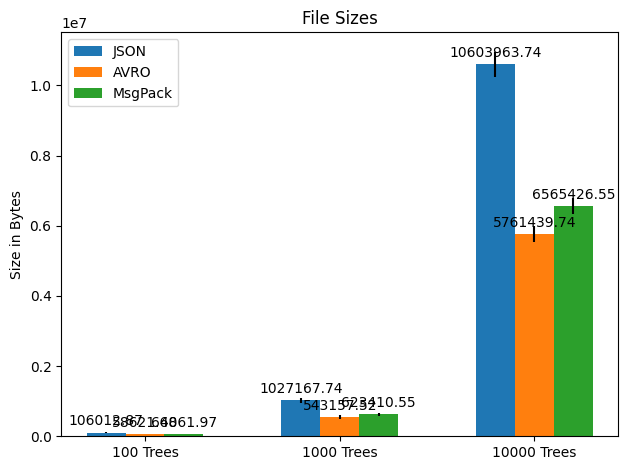

In [31]:
plot(sizes_100, sizes_1000, sizes_10000, ylabel="Size in Bytes", title="File Sizes")

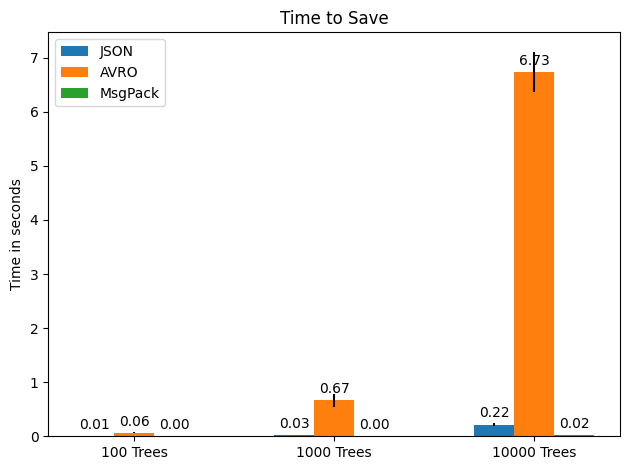

In [32]:
plot(save_100, save_1000, save_10000, ylabel="Time in seconds", title="Time to Save")

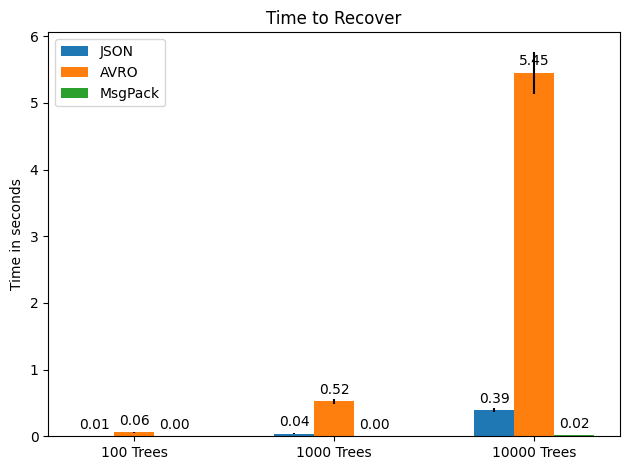

In [33]:
plot(load_100, load_1000, load_10000, ylabel="Time in seconds", title="Time to Recover")